# OPEN DATA BATTLE: **ПРОГНОЗИРОВАНИЕ ОШИБОК МОДЕЛИ**

---
## Содержание

* [Импорт модулей и функций](#Импорт-модулей-и-функций)
* [Подготовка данных: обработка пропусков, стандартизация](#Подготовка_данных:_обработка_пропусков,_стандартизация])
* [Задача классификации](#Задача_классификации)
* [Задача регрессии](#Задача_регрессии)
* [Объединение двух прогнозов](#Объединение_двух_прогнозов)
---

## Импорт модулей и функций

In [1]:
import random
import numpy as np
import pandas as pd

from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectKBest, chi2

from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score

## Подготовка данных: обработка пропусков, стандартизация

**data** – исходные данные: 1898 признаков и поле *flg_90_12_add (0, 1)* - целевое для модели банка  
**model** - спрогнозированные моделью банка вероятности дефолта (flg_90_12_add=1) для примеров в *data*  

In [5]:
data = pd.read_csv('_data/data.csv', sep=',')
model = pd.read_csv('_data/model.csv', sep=',')

data = pd.merge(data, model, on='incident') # добавление поля PD (probability of default)
data['ERROR'] = abs(data['PD']-data['flg_90_12_add']) # расчет ERROR (целевое поле задачи)

**realtest** – примеры с пропусками в целевом классе (примеры для сабмита)    
**data** - примеры для обучения и валидации модели прогнозирования ошибок модели банка

In [11]:
realtest = data[data['flg_90_12_add'].isnull()]  # submit-set
data = data[data['flg_90_12_add'].notnull()]  # train-set

print(f'train-set: {data.shape[0]} примеров')
print(f'submit-set: {realtest.shape[0]} примеров',)

train-set: 81617 примеров
submit-set: 1000 примеров


<AxesSubplot:ylabel='Frequency'>

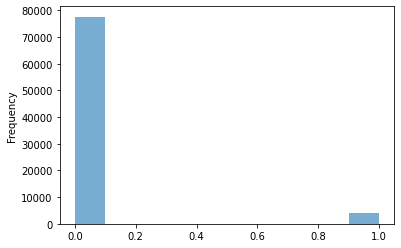

In [29]:
# Наблюдается сильная разбалансировка классов
data['flg_90_12_add'].plot.hist(alpha=0.6)

<AxesSubplot:ylabel='Frequency'>

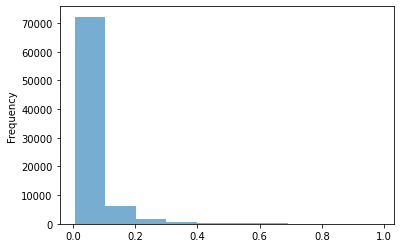

In [13]:
# Практически для всех примеров модель банка прогнозирует класс 0 (вероятности < 0.5)
data['PD'].plot.hist(alpha=0.6)

**Обработка пропусков в данных и скалирование**

Удаление из data и realtest столбцов с количеством пропусков > 50%  
Удаление из data и realtest строк с количеством пропусков > 50%  
Замена в data и realtest пропусков средними по полю значениями

In [26]:
data_cleaned = data.dropna(thresh=0.5*len(data), axis=1)
data_cleaned = data_cleaned.dropna(thresh=0.5*len(data_cleaned.columns), axis=0)

cols = data_cleaned.columns[3:-2] # только столбцы-признаки

scaler = MinMaxScaler()
scaler.fit(data_cleaned[cols])

data_scaled = scaler.transform(data_cleaned[cols])
data_scaled = pd.DataFrame(data_scaled, columns=cols, index=data_cleaned.index)

realtest_scaled = scaler.transform(realtest[cols])
realtest_scaled = pd.DataFrame(realtest_scaled, columns=cols)

for col in cols:
    v = data_scaled[col].mean()
    data_scaled[col].fillna(v, inplace=True)
    realtest_scaled[col].fillna(v, inplace=True)

print(f'data: {data.shape[1]} признаков --> data_scaled: {data_scaled.shape[1]} признаков')
print(f'data: {data.shape[0]} примеров --> data_scaled: {data_scaled.shape[0]} примеров')

data: 1912 признаков --> data_scaled: 416 признаков
data: 81617 примеров --> data_scaled: 71089 примеров


## Задача классификации
Целевая переменная - flg_90_12_add (0 - "не дефолт", 1 - "дефолт")  

Генерация нелинейных признаков  
Балансировка классов с применением SMOTE  
Прогнозирование моделью RandomForestClassifier

#### Генерация нелинейных признаков  
Так как все признаки анонимизированы, невозможно сделать предположения о том, какие из них следует  
использовать для feature engineering. Поэтому выбирается некоторое количество случайных признаков  
Новые признаки представляют собой произведение i-го и j-го признаков из списка rnd_cols

In [21]:
random.seed(42)

flg = data_cleaned['flg_90_12_add'] 
# data_scaled['ERROR'] = data_cleaned['ERROR']

rnd_cols = random.sample(list(cols), 5)
rnd_cols

['Feature_1247',
 'Feature_38',
 'Category_Feature_12',
 'Feature_1780',
 'Feature_491']

In [24]:
# Создание новых признаков в data 

new_cols = []
new_cols_name = []

for i in range(len(rnd_cols)):
    for j in range(i+1, len(rnd_cols)):
        
        xixj = str(rnd_cols[i]) + str(rnd_cols[j])
        new_cols.append(data_scaled[rnd_cols[i]] * data_scaled[rnd_cols[j]])
        new_cols_name.append(xixj)

new_cols_df = pd.concat(new_cols, axis=1)
new_cols_df.columns = new_cols_name
data_scaled_ex = pd.concat([data_scaled, new_cols_df], axis=1)

print(f'data_scaled_ex: {data_scaled_ex.shape[1]} признаков')

data_scaled_ex: 426 признаков


In [28]:
# Создание новых признаков в realtest

new_cols = []
new_cols_name = []

for i in range(len(rnd_cols)):
    for j in range(i+1, len(rnd_cols)):
        xixj = str(rnd_cols[i]) + str(rnd_cols[j])
        new_cols.append(realtest_scaled[rnd_cols[i]] * realtest_scaled[rnd_cols[j]])
        new_cols_name.append(xixj)

new_cols_df = pd.concat(new_cols, axis=1)
new_cols_df.columns= new_cols_name
realtest_scaled_ex = pd.concat([realtest_scaled, new_cols_df], axis=1)

print(f'realtest_scaled_ex: {realtest_scaled_ex.shape[1]} признаков')

realtest_scaled_ex: 426 признаков


#### Разбиение на train/test. Балансировка классов с применением SMOTE

In [31]:
X = data_scaled_ex
Y = data_cleaned['flg_90_12_add']

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.05, random_state=42)

print(f'train: {X_train.shape[0]} примеров')
print(f'test: {X_test.shape[0]} примеров')

train: 67534 примеров
test: 3555 примеров


#### Балансировка классов с применением SMOTE

In [32]:
smote = SMOTE(sampling_strategy='auto', k_neighbors=5, random_state=42)

X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

print(f'train_resampled: {X_train_resampled.shape[0]} примеров')



train_resampled: 128738 примеров


In [55]:
# Объемы классов после балансировки
y_train_resampled.value_counts()

0.0    64369
1.0    64369
Name: flg_90_12_add, dtype: int64

#### Обучение RandomForestClassifier

In [31]:
k = 120
min_samples_leaf = 3
n_estimators = 50

pipeline = Pipeline([('chi',  SelectKBest(chi2, k=k)),
                     ('clf', RandomForestClassifier(min_samples_leaf=min_samples_leaf,
                                                    n_estimators = n_estimators))])

model = pipeline.fit(X_train_resampled, y_train_resampled)

#### Оценка качества прогноза

In [37]:
y_pred_proba = model.predict_proba(X_test)
y_pred = model.predict(X_test)

accuracy_score(y_test, y_pred), f1_score(y_test, y_pred), recall_score(y_test, y_pred), precision_score(y_test, y_pred)

(0.9518987341772152,
 0.09523809523809525,
 0.05421686746987952,
 0.391304347826087)

In [91]:
for i in range(0, len(y_pred)):
    if y_pred[i]==1 and y_pred_proba[i][1]>0.7:
        print(y_pred_proba[i][1], y_pred[i] == np.array(y_test)[i])

0.7045714285714284 True
0.7509047619047616 True
0.7432597402597402 False
0.8344761904761903 True
0.8670952380952379 True


## Задача регрессии

Целевая переменная - ERROR (ошибка модели банка)

#### Разбиение на test/train

In [44]:
data_scaled['flg'] = data_cleaned['flg_90_12_add']
data_scaled['ERROR'] = data_cleaned['ERROR']

train, test = train_test_split(data_scaled, test_size=0.05, random_state=42)

train = train[train['flg']==0] # Обучение только на классе 0

X_train = train[cols]
X_test = test[cols]
y_train = train['ERROR']
y_test = test['ERROR']

# X_train.drop('flg', axis=1, inplace=True)
# X_test.drop('flg', axis=1, inplace=True)

X_train.shape, X_test.shape

((64369, 416), (3555, 416))

In [24]:
min_samples_leaf = 10
n_estimators = 15

model = RandomForestRegressor(min_samples_leaf=min_samples_leaf, 
                              n_estimators = n_estimators)

model = model.fit(X_train, y_train)
y_pred = model.predict(X_test)

mae(y_test, y_pred)

0.05837152817452408

## Объединение прогнозов

In [28]:
error_pred = y_pred

In [78]:
# Сабмит

# df = pd.DataFrame({'predict': predict})
# df.to_csv('subm2.csv', header=False, index=False)

# predict = model.predict(realtest_scaled)
# predict

array([0.0159881 , 0.09266114, 0.04786051, 0.11728369, 0.09209037,
       0.20325118, 0.08633979, 0.04675244, 0.14910278, 0.03964954,
       0.10930699, 0.08024007, 0.10280118, 0.15747415, 0.01902983,
       0.03156554, 0.07079532, 0.01654387, 0.01969884, 0.05964564,
       0.01176968, 0.01732379, 0.06366084, 0.02767264, 0.14143264,
       0.01343902, 0.17217146, 0.03071981, 0.21101838, 0.15684252,
       0.07206393, 0.21569843, 0.11027249, 0.0238011 , 0.01638294,
       0.04200898, 0.2492471 , 0.02463638, 0.11479311, 0.06249758,
       0.08396931, 0.03488316, 0.06489623, 0.01293245, 0.02079792,
       0.01331558, 0.02361767, 0.44534355, 0.14820625, 0.06764878,
       0.05311853, 0.04996046, 0.05439747, 0.21100259, 0.02634766,
       0.06895686, 0.07729938, 0.092236  , 0.05693918, 0.06375597,
       0.04531956, 0.09495757, 0.05041863, 0.01420843, 0.05949166,
       0.1160523 , 0.13001898, 0.05289264, 0.03446976, 0.03568507,
       0.04757946, 0.17401495, 0.13976265, 0.10056091, 0.16199

In [39]:
error_pred

array([0.02012371, 0.0211227 , 0.09648843, ..., 0.01833095, 0.02291858,
       0.06771428])

In [38]:
y_pred_proba

array([[1.        , 0.        ],
       [1.        , 0.        ],
       [0.94968254, 0.05031746],
       ...,
       [0.984     , 0.016     ],
       [0.92717172, 0.07282828],
       [0.83610317, 0.16389683]])

In [64]:
predict_combine = []

for i in range(len(error_pred)):
    if y_pred_proba[i][1] > 0.7:
        predict_combine.append(0.8)
        print(y_pred_proba[i][1])
    else: predict_combine.append(error_pred[i])

0.7234999999999999
0.841547619047619
0.7271190476190477
0.7245238095238095


In [65]:
mae(y_test, predict_combine)

0.05765522486888258